# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Описание данных: <br>

Признаки: <br>
* DateCrawled — дата скачивания анкеты из базы<br>
* VehicleType — тип автомобильного кузова<br>
* RegistrationYear — год регистрации автомобиля<br>
* Gearbox — тип коробки передач<br>
* Power — мощность (л. с.)<br>
* Model — модель автомобиля<br>
* Kilometer — пробег (км)<br>
* RegistrationMonth — месяц регистрации автомобиля<br>
* FuelType — тип топлива<br>
* Brand — марка автомобиля<br>
* NotRepaired — была машина в ремонте или нет<br>
* DateCreated — дата создания анкеты<br>
* NumberOfPictures — количество фотографий автомобиля<br>
* PostalCode — почтовый индекс владельца анкеты (пользователя)<br>
* LastSeen — дата последней активности пользователя<br>

Целевой признак:<br>
* Price — цена (евро)<br>

## Подготовка данных

Начнём с импортов:

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder 

In [2]:
date_columns = ['DateCrawled', 'DateCreated']
data = pd.read_csv('/datasets/autos.csv', parse_dates=date_columns)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Пропусков относительно много, но они в категориальных переменных. Так и напрашивается заполнить их 'unknown'

In [5]:
data = data.fillna('unknown')

Проверим аномальные значения годов регистрации автомобиля. Они не могут быть новее даты скачивания анкеты.

In [6]:
data[data['RegistrationYear'] > data['DateCrawled'].dt.year]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
22,2016-03-23 14:52:51,2900,unknown,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,unknown,2017,manual,125,c4,125000,4,unknown,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,unknown,2017,manual,80,golf,100000,1,petrol,volkswagen,unknown,2016-03-25,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,unknown,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07,0,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,unknown,2018,manual,64,other,125000,3,unknown,seat,no,2016-03-10,0,33397,2016-03-25 10:17:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354112,2016-03-11 15:49:51,3600,unknown,2017,manual,86,transit,150000,5,gasoline,ford,unknown,2016-03-11,0,32339,2016-03-12 05:45:02
354140,2016-03-29 16:47:29,1000,unknown,2017,manual,101,a4,150000,9,unknown,audi,unknown,2016-03-29,0,38315,2016-04-06 02:44:27
354203,2016-03-17 00:56:26,2140,unknown,2018,manual,80,fiesta,150000,6,unknown,ford,no,2016-03-17,0,44866,2016-03-29 15:45:04
354253,2016-03-25 09:37:59,1250,unknown,2018,unknown,0,corsa,150000,0,petrol,opel,unknown,2016-03-25,0,45527,2016-04-06 07:46:13


Избавимся от этих значений.

In [7]:
data = data[data['RegistrationYear'] <= data['DateCrawled'].dt.year]

Удалим ненужные для решения задачи признаки.

In [8]:
data = data.drop(['DateCrawled','RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis = 1)

Проверим и удалим дубликаты.

In [9]:
data[data.duplicated()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1117,950,small,1999,manual,60,polo,150000,petrol,volkswagen,no
1396,0,unknown,2000,unknown,0,unknown,150000,unknown,volvo,unknown
2169,0,coupe,2002,manual,129,c_klasse,150000,petrol,mercedes_benz,no
2833,1499,small,2001,manual,58,corsa,150000,petrol,opel,no
3025,2800,wagon,2005,unknown,0,touran,150000,gasoline,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
354352,6500,sedan,2003,auto,145,e_klasse,150000,gasoline,mercedes_benz,no
354355,4400,sedan,2008,manual,105,leon,150000,gasoline,seat,no
354358,1490,small,1998,manual,50,lupo,150000,petrol,volkswagen,no
354359,7900,sedan,2010,manual,140,golf,150000,gasoline,volkswagen,no


In [10]:
data = data.drop_duplicates().reset_index(drop=True)

Теперь построим гистрограммы по 'Price', 'Power' и 'Kilometer'

Поставим небольшой range, дорогие машины не есть аномалия, в отличие от бесплатных.

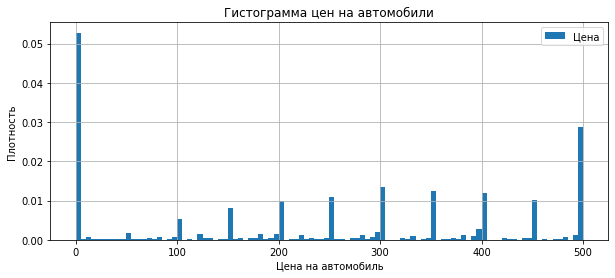

In [11]:
data['Price'].hist(bins = 100, density = 'True', label = 'Цена', alpha = 1, range = (0, 500), figsize = (10, 4))

plt.xlabel('Цена на автомобиль')
plt.ylabel('Плотность')
plt.title('Гистограмма цен на автомобили')
plt.legend()
plt.show()

Удалю машины стоимостью меньше 50 евро. Будем считать, что их отдают просто в добрые руки. Судя по пикам, цена в 50 и более осознонная и обосновывается состоянием машины.

In [12]:
data = data[data['Price'] >= 50]

Проверим мощность.

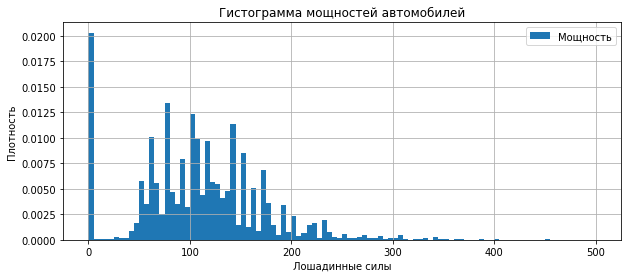

In [13]:
data['Power'].hist(bins = 100, density = 'True', label = 'Мощность', range = (0, 500), alpha = 1, figsize = (10, 4))

plt.xlabel('Лошадинные силы')
plt.ylabel('Плотность')
plt.title('Гистограмма мощностей автомобилей')
plt.legend()
plt.show()

Не слишком разбираюсь в машинах, но, изучев вопрос, выяснил, что максимальная л.с. равна 1600. Как таковой минимальной нет, но "нижний сегмент" от 80 до 110 лошадей. Здесь ограничу данные промежутком от 50 до 1600.

In [14]:
data = data[(data['Power'] >= 50) & (data['Power'] <= 1600)]

Теперь посмотрим на 'Kilometer' .

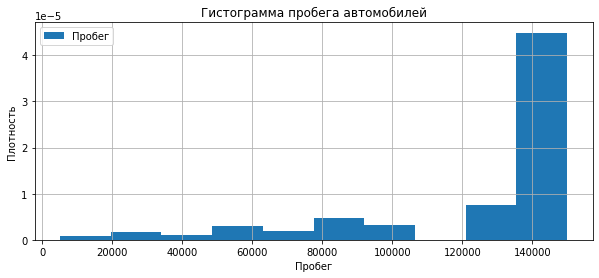

In [15]:
data['Kilometer'].hist(bins = 10, density = 'True', label = 'Пробег', alpha = 1, figsize = (10, 4))

plt.xlabel('Пробег')
plt.ylabel('Плотность')
plt.title('Гистограмма пробега автомобилей')
plt.legend()
plt.show()

Похоже, без вбросов.

Скопируем наш датасет для подготовки данных к трём разным моделям.

In [16]:
data_linear = data.copy()
data_tree = data.copy()

### Данные для линейной модели

Используем OHE.

In [17]:
data_linear = pd.get_dummies(data_linear, drop_first=True)

Разделим данные в соотношении 60-20-20%

In [18]:
features_linear = data_linear.drop('Price', axis = 1)
target_linear = data_linear['Price']

In [19]:
features_linear_train, features_linear_remaining, target_linear_train, target_linear_remaining = train_test_split(features_linear, target_linear, train_size=0.6, random_state = 123456)
features_linear_valid, features_linear_test, target_linear_valid, target_linear_test = train_test_split(features_linear_remaining,target_linear_remaining, test_size=0.5, random_state = 123456)
print("Обучающая выборка:", features_linear_train.shape, target_linear_train.shape)
print("Валидационная выборка:", features_linear_valid.shape, target_linear_valid.shape)
print("Тестовая выборка:", features_linear_test.shape, target_linear_test.shape)

Обучающая выборка: (151276, 310) (151276,)
Валидационная выборка: (50425, 310) (50425,)
Тестовая выборка: (50426, 310) (50426,)


Скалируем численные признаки

In [20]:
numeric = ['Power', 'Kilometer'] #численные признаки

pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_linear_train[numeric]) 
features_linear_train[numeric] = scaler.transform(features_linear_train[numeric])
features_linear_valid[numeric] = scaler.transform(features_linear_valid[numeric]) 
features_linear_test[numeric] = scaler.transform(features_linear_test[numeric])

### Данные для дерева регресии

Всё тоже самое, только используем OE и не производим скалирование

In [21]:
encoder = OrdinalEncoder() 

In [22]:
data_tree = pd.DataFrame(encoder.fit_transform(data_tree),
                            columns=data.columns)

In [23]:
features_tree = data_tree.drop('Price', axis = 1)
target_tree = data_tree['Price']

In [24]:
features_tree_train, features_tree_remaining, target_tree_train, target_tree_remaining = train_test_split(features_tree,target_tree, train_size=0.6, random_state = 123456)
features_tree_valid, features_tree_test, target_tree_valid, target_tree_test = train_test_split(features_tree_remaining,target_tree_remaining, test_size=0.5, random_state = 123456)
print("Обучающая выборка:", features_tree_train.shape, target_tree_train.shape)
print("Валидационная выборка:", features_tree_valid.shape, target_tree_valid.shape)
print("Тестовая выборка:", features_tree_test.shape, target_tree_test.shape)

Обучающая выборка: (151276, 9) (151276,)
Валидационная выборка: (50425, 9) (50425,)
Тестовая выборка: (50426, 9) (50426,)


### Данные для LightGBM

Здесь переводим категориальные признаки в тип данных 'category'.

In [25]:
data = data.astype({'VehicleType': 'category','RegistrationYear': 'category', 'Gearbox': 'category', 
                    'Model': 'category', 'FuelType': 'category', 'Brand': 'category', 'NotRepaired': 'category'})

In [26]:
features = data.drop('Price', axis = 1)
target = data['Price']

In [27]:
features_train, features_remaining, target_train, target_remaining = train_test_split(features,target, train_size=0.6, random_state = 123456)
features_valid, features_test, target_valid, target_test = train_test_split(features_remaining,target_remaining, test_size=0.5, random_state = 123456)
print("Обучающая выборка:", features_train.shape, target_train.shape)
print("Валидационная выборка:", features_valid.shape, target_valid.shape)
print("Тестовая выборка:", features_test.shape, target_test.shape)

Обучающая выборка: (151276, 9) (151276,)
Валидационная выборка: (50425, 9) (50425,)
Тестовая выборка: (50426, 9) (50426,)


In [28]:
numeric = ['Power', 'Kilometer'] #численные признаки

pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_linear_train[numeric] = scaler.transform(features_train[numeric])
features_linear_valid[numeric] = scaler.transform(features_valid[numeric]) 
features_linear_test[numeric] = scaler.transform(features_test[numeric])

## Обучение моделей

### Линейная регрессия

Начнём со знакомых моделей и перейдём к градиентному бустингу в последнюю очередь.

In [29]:
linear_model = LinearRegression().fit(features_linear_train, target_linear_train)
linear_predictions = linear_model.predict(features_linear_valid)
print('RMSE-модели:', sqrt(mean_squared_error(target_linear_valid, linear_predictions)))

RMSE-модели: 2750.908532754182


### Дерево регресии

In [30]:
tree_model = DecisionTreeRegressor().fit(features_tree_train, target_tree_train)

In [31]:
print('RMSE-модели:', sqrt(mean_squared_error(target_tree_valid, tree_model.predict(features_tree_valid))))

RMSE-модели: 400.23606345180264


C помощью GridSearсh оптимизируем глубину дерева.

In [32]:
%%time
parameters = {'max_depth': range(2, 21, 2)}
tree_GS = GridSearchCV(tree_model, param_grid = parameters, scoring = 'neg_root_mean_squared_error')
tree_GS.fit(features_tree_train, target_tree_train)

CPU times: user 11.9 s, sys: 103 ms, total: 12 s
Wall time: 12 s


GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(2, 21, 2)},
             scoring='neg_root_mean_squared_error')

In [33]:
tree_GS.best_params_

{'max_depth': 14}

### LightGBM 

In [34]:
light_model = lgb.LGBMRegressor().fit(features_train, target_train)

In [35]:
print('RMSE-модели:', sqrt(mean_squared_error(target_valid, light_model.predict(features_valid))))

RMSE-модели: 1626.353953115767


In [36]:
%%time
parameters = {
    'max_depth': [5, 7, 10],
    'learning_rate': [0.5, 0.6, 0.7]}

light_GS = GridSearchCV(light_model, param_grid = parameters, scoring = 'neg_root_mean_squared_error')
light_GS.fit(features_train, target_train)

CPU times: user 2min 43s, sys: 0 ns, total: 2min 43s
Wall time: 2min 45s


GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.5, 0.6, 0.7],
                         'max_depth': [5, 7, 10]},
             scoring='neg_root_mean_squared_error')

In [37]:
light_GS.best_params_

{'learning_rate': 0.5, 'max_depth': 5}

Вычислили RMSE для каждой из моделей. Заодно нашли оптимальные гиперпараметры. <br>
Уже на данном этапе можем сказать, что с LightGBM получаются более точные предсказания, но вот считает она долго. <br>

В следующем шаге запустим все модели с оптимальными параметрами, посчитаем RMSE и время исполнения кода. Запишем результаты в итоговую таблицу.

## Анализ моделей

Подготовим таблицу для результатов.

In [38]:
summary = defaultdict(list)

Подозреваю, что предполагалось использование %%time, но т.к. мне нужно сохранить время в переменную, прибегнем к time.time()

In [39]:
def check_models(model):
    tic = time.time()
    count = sqrt(mean_squared_error(target_test, model.predict(features_test)))
    toc = time.time()
    return count, toc-tic

### Линейная регрессия

In [40]:
tic = time.time()
linear_model = LinearRegression().fit(features_linear_train, target_linear_train)
toc = time.time()
summary['Learning time'].append(toc - tic)

In [41]:
tic = time.time()
pred = linear_model.predict(features_linear_test)
toc = time.time()
summary['Predicting time'].append(toc - tic)
summary['RMSE'].append(sqrt(mean_squared_error(target_linear_test, pred)))

### Дерево регрессии

In [42]:
tic = time.time()
tree_model = DecisionTreeRegressor(random_state = 123456, max_depth = 14).fit(features_tree_train, target_tree_train)
toc = time.time()
summary['Learning time'].append(toc - tic)

In [43]:
tic = time.time()
pred = tree_model.predict(features_tree_test)
toc = time.time()
summary['Predicting time'].append(toc - tic)
summary['RMSE'].append(sqrt(mean_squared_error(target_tree_test, pred)))

### LightGBM

In [44]:
tic = time.time()
light_model = lgb.LGBMRegressor(learning_rate = 0.5, max_depth = 10, random_state = 123456).fit(features_train, target_train)
toc = time.time()
summary['Learning time'].append(toc - tic)

In [45]:
tic = time.time()
pred = light_model.predict(features_test)
toc = time.time()
summary['Predicting time'].append(toc - tic)
summary['RMSE'].append(sqrt(mean_squared_error(target_test, light_model.predict(features_test))))

Посмотрим, что у нас получилось:

In [46]:
df_summary = pd.DataFrame(summary, index = ['Линейная регрессия', 'Дерево регрессии', 'LightGBM'])
df_summary.head()

,Learning time,Predicting time,RMSE
Линейная регрессия,14.175361,0.109849,2741.480933
Дерево регрессии,0.498018,0.010497,371.399659
LightGBM,3.965192,0.394816,1646.127205


Любопытные результаты, сравнивая с предыдущим шагом. Похоже, ход работы LightGBM не так уж продолжителен при заранее определенных параметрах, но вот их подбор занимает колоссальное время.

Проверил дерево регрессии, пока не понял, в чем ошибка. Но очень похоже, что что-то не так. Попробуем ещё и RandomForest.

In [47]:
new_tree_model = RandomForestRegressor(random_state = 123456, n_estimators = 10, max_depth = 14).fit(features_tree_train, target_tree_train)
result = sqrt(mean_squared_error(target_tree_test, new_tree_model.predict(features_tree_test)))
print('Проверка:', result)

Проверка: 332.9953313163183


Похоже, что-то с ОЕ.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей

## Выводы

В результате выполнения проекта построена модель для определения стоимости автомобилей сервиса «Не бит, не крашен».<br>
Обучены три модели - Линейная регрессия, Деревья регрессии и LightGBM. Вычислен RMSE для каждой и модели и посчитано время выполнения кода.<br>

In [48]:
df_summary

,Learning time,Predicting time,RMSE
Линейная регрессия,14.175361,0.109849,2741.480933
Дерево регрессии,0.498018,0.010497,371.399659
LightGBM,3.965192,0.394816,1646.127205


Несмотря на то, что LightGBM показала лучший RMSE и делала прогноз не сильно дольше Дерева регрессий, стоит заметить, что подбор оптимальных гиперпараметров занял наибольшее время, хотя менялись только параметры learning_rate и max_depth.  